In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import uuid #to generate random id
import pickle #to save/load list of selected hens

#test equal variance
from scipy.stats import levene

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
from scipy.stats import pearsonr, spearmanr 
import scipy.stats as stats

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp #for barplot
from mpl_toolkits.mplot3d import Axes3D

In [69]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import chi2_distance, ts_visual, time_series_henColumn_tsRow, correct_key, kmeans_clustering, pca_fct
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
rv = 0

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
#id_run = 'chapter0_final_'
#path_dataoutput = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput'
#path_extracted_data = os.path.join(path_dataoutput,'TrackingSystem') 
#path_extracted_data = os.path.join(path_extracted_data, id_run)
dico_night_hour = config.dico_night_hour
dico_matching = config.dico_matching
li_binmn = config.li_binmn
penalty = config.penalty
dico_window = config.dico_window
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
print(id_run)

change the configuration file if not done yet!
correctlightschedule_


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
rv = 0

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [6]:
#selected hens
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap,'li_selected_hens.pkl'), 'rb'))
len(li_selected_hens)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


131

In [7]:
df_interintra = pd.read_csv(os.path.join(path_extracted_data_visual_adap, id_run+'_df_DistanceBetweenHenSim.csv'), 
                            sep=';') 
df_interintra['DTW_15_all'] = df_interintra[['DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone']].sum(axis=1)
print(df_interintra.shape)
df_interintra.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(212264, 97)


,level1,level2,henID1,henID2,dur_values_normalized_henID1,dur_values_normalized_henID2,chi2distance,DOA,WOA,nbr_obs_chi2all_5,...,nbr_obs_l2_30_5_Zone,DTW_30_4_Zone,nbr_obs_l1_30_4_Zone,nbr_obs_l2_30_4_Zone,DTW_30_1_Zone,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,weeks_in_laying_barn,hen_pair,DTW_15_all
0,2020-09-30,2020-09-30,hen_1,hen_10,"[0.0, 0.6557638888888889, 0.12111111111111111,...","[0.0, 0.40243055555555557, 0.5327083333333333,...",0.233889,119,17,288,...,48,21.0,48,48,0.0,48,48,1,hen_1-hen_10,315.1
1,2020-09-30,2020-09-30,hen_2,hen_47,"[0.0, 0.3379861111111111, 0.23836805555555557,...","[0.0, 0.8774305555555556, 0.11180555555555556,...",0.341557,119,17,288,...,48,31.8,48,48,0.0,48,48,1,hen_2-hen_47,166.6
2,2020-09-30,2020-09-30,hen_2,hen_46,"[0.0, 0.3379861111111111, 0.23836805555555557,...","[0.0, 0.2679861111111111, 0.059409722222222225...",0.110694,119,17,288,...,48,124.6,48,48,0.0,48,48,1,hen_2-hen_46,341.3


# Visualise the similarity between two individuals over time

In [8]:
li_dist = ['chi2distance_ALL_15', 'chi2distance', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone','DTW_15_all']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


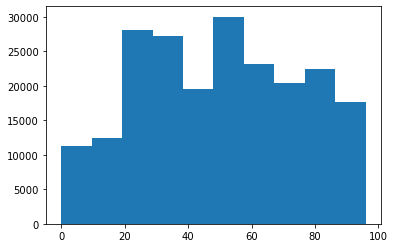

In [9]:
plt.hist(df_interintra['chi2distance_ALL_15']);

### Hens similarities across time

In [29]:
#with regression line
for V in li_dist:
    
    df_pair = df_interintra.pivot(index='hen_pair', columns='DOA', values=V).reset_index()
    print(df_pair.shape)
    display(df_pair.head(3))

    li_DOA = list(range(119,max(df_interintra['DOA'].tolist())+1))
    li_DOA = list(range(119,119+18))
    col_ = len(li_DOA)
    lign_ = len(li_DOA)
    fig = plt.figure(figsize=(3*lign_, 3*col_))
    i = 1
    #enumerate across x
    for k1,D1 in tqdm.tqdm(enumerate(li_DOA)):
        #enumerate across y
        for k2,D2 in enumerate(li_DOA):

            if k2<=k1:
                plt.subplot(lign_,col_,i)
                plt.tight_layout()
                i = i+1
                plt.xticks([]) #remove xlabel annotations
                plt.yticks([])
                plt.axis('off');
            else:
                #initialize subplot
                plt.subplot(lign_,col_,i)
                plt.tight_layout()
                i = i+1
                plt.xticks([]) #remove xlabel annotations
                plt.yticks([])
                plt.axis('off');

                #data
                if (D1 in df_pair.columns) & (D2 in df_pair.columns) :
                    df_ = df_pair[[D1,D2]]
                    df_ = df_[~(df_.isnull().any(axis=1))]
                    x = np.array(df_[D1].tolist())
                    y = np.array(df_[D2].tolist())
                    #if at least 10 observations
                    if (len(x)>0) & (len(x)==len(y)):
                        #measures
                        Explvarscore = explained_variance_score(x, y)
                        RMSE = math.sqrt(mean_squared_error(x, y))
                        MAE = mean_absolute_error(x, y)
                        #Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets
                        #rcoeff2, p_value2 = pearsonr(x, y)
                        rcoeff2, p_value2 = spearmanr(x, y)
                        try:
                            #linear model & it's the 95% CI
                            slope, intercept = np.polyfit(x, y, 1) #degree=1: fit a linear model SVD in Linear Least Squares
                            #TODO: check assumption??? or not as not really using it besides visual?
                            y_model = np.polyval([slope, intercept], x) #evaluate the y_pred by the model
                            x_mean = np.mean(x) ; y_mean = np.mean(y)
                            n = x.size                        # number of samples
                            dof = n - 2                       # degrees of freedom: size-#parameters
                            t_ = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence
                            residual = y - y_model

                            ############### Plot
                            plt.rcParams.update({'font.size': 11})

                            #plot middle line and 95% IC
                            x_line = np.linspace(np.min(x), np.max(x), 100)
                            y_line = np.polyval([slope, intercept], x_line)
                            # confidence interval
                            std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error
                            ci = t_ * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
                            plt.plot(x_line, y_line, color='black', linewidth=9)
                        except Exception as e:
                            print(e)
                            pass
                        #ax.fill_between(x_line, y_line + ci, y_line - ci, alpha=0.5, color='black') #label = '95% confidence interval', 
                        xl = int(max(df_interintra[V].tolist()))+1
                        yl = int(max(df_interintra[V].tolist()))+1
                        plt.xlim(0,xl)
                        plt.ylim(0,yl)
                        #add text
                        #plt.set_xlabel(D1)
                        #plt.set_ylabel(D2)
                        #ax.text(0, max(y)-int(0.12*max(y))+epsi, 'Explained variance score = ' + str(np.round(Explvarscore,2)))
                        #ax.text(0, max(y)-int(0.24*max(y))+epsi, 'RMSE = ' + str(np.round(RMSE,2)) +\
                        #                                    '     MAE = ' + str(np.round(MAE,2)))
                        #plt.text(0.03, 0.9-int(0.36*0.9), 'spearmanr coef = ' + str(np.round(rcoeff2,2)))
                        #plt.text(0.03, 0.8-int(0.36*0.8), 'spearmanr p-value = ' + str(np.round(p_value2,3)))
                        plt.text(0.1, int(yl*0.95), 'spearmanr coef = ' + str(np.round(rcoeff2,2)))
                        plt.text(0.1, int(yl*0.95), 'spearmanr p-value = ' + str(np.round(p_value2,3)))

                        #plot points with size equal to the amount of points (as count data)
                        # count the occurrences of each point
                        c = Counter(zip(x,y))
                        # create a list of the sizes, here multiplied by 10 for scale
                        s = [1.9*c[(xx,yy)] for xx,yy in zip(x,y)]
                        if p_value2<0.001:
                            plt.scatter(x, y, s=s, color='red') 
                        elif p_value2<0.01:
                            plt.scatter(x, y, s=s, color='orange') 
                        elif p_value2<0.05:
                            plt.scatter(x, y, s=s, color='yellow') 
                        elif p_value2>0.05:
                            plt.scatter(x, y, s=s, color='blue') 
                        else:
                            plt.scatter(x, y, s=s, color='green')
                        #plt.legend(bbox_to_anchor=(1, .25), fontsize=12);

                        #add diagonal line
                        #ax.axline((0, 0), slope=1, c="black", ls="--", zorder=0)
                        plt.title('x: '+str(D1)+'  y: '+str(D2));
    #save
    plt.savefig(os.path.join(path_extracted_data_visual_adap, 'HensSimilaritiesAcrosstime_'+V+'_'+str(col_)+'.png'), dpi=400, 
                bbox_inches='tight')
    plt.clf()

(8515, 30)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,82.616001,52.387654,0.431335,NaN,NaN,NaN,44.659625,89.320389,60.429706,...,0.000000,26.338297,40.702363,14.624763,7.487880,21.936624,32.627396,42.098160,47.358855,18.770556
1,hen_1-hen_101,75.844071,85.075360,96.000000,NaN,NaN,NaN,48.129701,92.486211,93.803084,...,53.754848,55.426084,42.038528,57.593855,62.867608,71.645071,94.689979,88.694261,91.595477,91.399992
2,hen_1-hen_102,28.154131,16.129158,0.431335,NaN,NaN,NaN,34.475205,37.297765,0.000000,...,23.190487,28.097817,3.188111,2.810832,2.244541,9.544140,4.721244,13.097191,2.994832,19.661801


18it [02:20,  7.79s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,0.233889,0.322369,0.008576,NaN,NaN,NaN,0.004816,0.618510,0.542879,...,0.000000,0.032912,0.211068,0.172145,0.091667,0.326435,0.530965,0.180796,0.283903,0.209466
1,hen_1-hen_101,0.126262,0.412330,0.969064,NaN,NaN,NaN,0.296610,0.892051,0.913367,...,0.429268,0.545147,0.245100,0.525370,0.812119,0.881123,0.959806,0.783503,0.822982,0.817856
2,hen_1-hen_102,0.485570,0.299795,0.008576,NaN,NaN,NaN,0.181576,0.015801,0.000000,...,0.061833,0.042358,0.035847,0.034631,0.028180,0.114149,0.055473,0.163323,0.047442,0.079502


18it [02:17,  7.62s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,51.0,44.3,0.0,NaN,NaN,NaN,56.8,55.6,58.6,...,0.0,0.9,44.0,34.5,36.2,43.3,51.4,41.6,61.9,58.6
1,hen_1-hen_101,128.5,109.7,80.2,NaN,NaN,NaN,53.7,72.5,69.7,...,56.9,64.0,35.3,59.1,72.2,79.9,79.0,74.4,79.9,74.3
2,hen_1-hen_102,68.3,44.3,0.0,NaN,NaN,NaN,44.5,0.0,0.0,...,19.3,2.2,0.0,0.0,0.0,41.1,12.7,36.7,5.1,23.2


18it [02:12,  7.35s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,127.5,94.6,8.9,NaN,NaN,NaN,75.7,121.0,93.7,...,0.0,74.6,76.0,29.0,5.0,21.8,37.6,80.7,70.6,15.2
1,hen_1-hen_101,100.6,72.8,120.2,NaN,NaN,NaN,72.9,116.4,34.3,...,33.4,40.6,38.2,40.3,41.1,40.9,86.1,108.8,78.2,51.5
2,hen_1-hen_102,24.2,32.2,8.9,NaN,NaN,NaN,73.7,91.3,0.0,...,67.0,75.0,17.8,17.8,11.7,4.6,17.3,16.7,21.0,14.5


18it [02:04,  6.92s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,14.3,25.1,0.0,NaN,NaN,NaN,21.7,43.6,32.8,...,0.0,15.5,34.7,28.5,11.7,40.6,50.6,29.6,40.8,42.1
1,hen_1-hen_101,6.4,0.0,1.0,NaN,NaN,NaN,71.7,87.9,116.3,...,81.6,74.2,76.2,73.8,69.0,79.5,68.7,9.5,85.2,95.8
2,hen_1-hen_102,10.9,0.0,0.0,NaN,NaN,NaN,15.2,3.9,0.0,...,7.5,23.8,16.4,12.7,15.5,10.8,17.0,16.9,6.1,49.5


18it [02:05,  6.96s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,122.3,101.7,8.9,NaN,NaN,NaN,91.0,141.6,116.5,...,0.0,76.7,95.6,56.5,40.3,69.0,85.2,97.2,93.2,41.6
1,hen_1-hen_101,82.6,133.1,146.3,NaN,NaN,NaN,65.6,110.2,145.2,...,109.2,110.9,96.3,113.2,118.6,126.7,145.8,140.7,136.7,134.5
2,hen_1-hen_102,69.3,59.9,8.9,NaN,NaN,NaN,88.0,91.5,0.0,...,71.8,79.0,26.4,24.1,21.5,46.1,32.1,53.9,5.7,66.0


18it [02:05,  7.00s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,315.1,265.7,17.8,NaN,NaN,NaN,245.2,361.8,301.6,...,0.0,167.7,250.3,148.5,93.2,174.7,224.8,249.1,266.5,161.6
1,hen_1-hen_101,318.1,315.6,347.7,NaN,NaN,NaN,263.9,387.0,365.5,...,288.7,298.4,246.0,306.9,329.7,334.7,395.4,355.8,385.2,389.5
2,hen_1-hen_102,172.7,136.4,17.8,NaN,NaN,NaN,221.4,186.7,0.0,...,165.6,180.0,60.6,54.6,48.7,102.6,79.1,142.3,37.9,170.1


18it [02:03,  6.87s/it]


<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

### Square similarities assocaition matrix

In [30]:
del li_DOA
#with regression line
for V in li_dist:
    
    df_pair = df_interintra.pivot(index='hen_pair', columns='DOA', values=V).reset_index()
    print(df_pair.shape)
    display(df_pair.head(3))
    col_ = 18
    lign_ = 18
    fig = plt.figure(figsize=(3*lign_, 3*col_))
    i = 1
    #enumerate across x
    for k1,D1 in tqdm.tqdm(enumerate(range(119,119+col_))):
        #enumerate across y
        for k2,D2 in enumerate(range(119+col_,119+col_+col_)):

            #initialize subplot
            plt.subplot(lign_,col_,i)
            plt.tight_layout()
            i = i+1
            plt.xticks([]) #remove xlabel annotations
            plt.yticks([])
            plt.axis('off');

            #data
            if (D1 in df_pair.columns) & (D2 in df_pair.columns) :
                df_ = df_pair[[D1,D2]]
                df_ = df_[~(df_.isnull().any(axis=1))]
                x = np.array(df_[D1].tolist())
                y = np.array(df_[D2].tolist())
                #if at least 10 observations
                if (len(x)>0) & (len(x)==len(y)):
                    #measures
                    Explvarscore = explained_variance_score(x, y)
                    RMSE = math.sqrt(mean_squared_error(x, y))
                    MAE = mean_absolute_error(x, y)
                    #Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets
                    #rcoeff2, p_value2 = pearsonr(x, y)
                    rcoeff2, p_value2 = spearmanr(x, y)
                    try:
                        #linear model & it's the 95% CI
                        slope, intercept = np.polyfit(x, y, 1) #degree=1: fit a linear model SVD in Linear Least Squares
                        #TODO: check assumption??? or not as not really using it besides visual?
                        y_model = np.polyval([slope, intercept], x) #evaluate the y_pred by the model
                        x_mean = np.mean(x) ; y_mean = np.mean(y)
                        n = x.size                        # number of samples
                        dof = n - 2                       # degrees of freedom: size-#parameters
                        t_ = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence
                        residual = y - y_model

                        ############### Plot
                        plt.rcParams.update({'font.size': 11})

                        #plot middle line and 95% IC
                        x_line = np.linspace(np.min(x), np.max(x), 100)
                        y_line = np.polyval([slope, intercept], x_line)
                        # confidence interval
                        std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error
                        ci = t_ * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
                        plt.plot(x_line, y_line, color='black', linewidth=9)
                    except Exception as e:
                        print(e)
                        pass
                    #ax.fill_between(x_line, y_line + ci, y_line - ci, alpha=0.5, color='black') #label = '95% confidence interval', 
                    xl = int(max(df_interintra[V].tolist()))+1
                    yl = int(max(df_interintra[V].tolist()))+1
                    plt.xlim(0,xl)
                    plt.ylim(0,yl)
                    #add text
                    #plt.set_xlabel(D1)
                    #plt.set_ylabel(D2)
                    #ax.text(0, max(y)-int(0.12*max(y))+epsi, 'Explained variance score = ' + str(np.round(Explvarscore,2)))
                    #ax.text(0, max(y)-int(0.24*max(y))+epsi, 'RMSE = ' + str(np.round(RMSE,2)) +\
                    #                                    '     MAE = ' + str(np.round(MAE,2)))
                    #plt.text(0.03, 0.9-int(0.36*0.9), 'spearmanr coef = ' + str(np.round(rcoeff2,2)))
                    #plt.text(0.03, 0.8-int(0.36*0.8), 'spearmanr p-value = ' + str(np.round(p_value2,3)))
                    plt.text(0.1, int(yl*0.95), 'spearmanr coef = ' + str(np.round(rcoeff2,2)))
                    plt.text(0.1, int(yl*0.85), 'spearmanr p-value = ' + str(np.round(p_value2,3)))
                    
                    
                    #plot points with size equal to the amount of points (as count data)
                    # count the occurrences of each point
                    c = Counter(zip(x,y))
                    # create a list of the sizes, here multiplied by 10 for scale
                    s = [1.9*c[(xx,yy)] for xx,yy in zip(x,y)]
                    if p_value2<0.001:
                        plt.scatter(x, y, s=s, color='red') 
                    elif p_value2<0.01:
                        plt.scatter(x, y, s=s, color='orange') 
                    elif p_value2<0.05:
                        plt.scatter(x, y, s=s, color='yellow') 
                    elif p_value2>=0.05:
                        plt.scatter(x, y, s=s, color='blue') 
                    else:
                        plt.scatter(x, y, s=s, color='green')
                    #plt.legend(bbox_to_anchor=(1, .25), fontsize=12);

                    #add diagonal line
                    #ax.axline((0, 0), slope=1, c="black", ls="--", zorder=0)
                    plt.title('x: '+str(D1)+'  y: '+str(D2));
    #save
    plt.savefig(os.path.join(path_extracted_data_visual_adap, 'HensSimilaritiesAcrosstime_SQUARE_'+V+'_'+str(col_)+'.png'), 
                dpi=600)
    plt.clf()

(8515, 30)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,82.616001,52.387654,0.431335,NaN,NaN,NaN,44.659625,89.320389,60.429706,...,0.000000,26.338297,40.702363,14.624763,7.487880,21.936624,32.627396,42.098160,47.358855,18.770556
1,hen_1-hen_101,75.844071,85.075360,96.000000,NaN,NaN,NaN,48.129701,92.486211,93.803084,...,53.754848,55.426084,42.038528,57.593855,62.867608,71.645071,94.689979,88.694261,91.595477,91.399992
2,hen_1-hen_102,28.154131,16.129158,0.431335,NaN,NaN,NaN,34.475205,37.297765,0.000000,...,23.190487,28.097817,3.188111,2.810832,2.244541,9.544140,4.721244,13.097191,2.994832,19.661801


18it [02:37,  8.76s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,0.233889,0.322369,0.008576,NaN,NaN,NaN,0.004816,0.618510,0.542879,...,0.000000,0.032912,0.211068,0.172145,0.091667,0.326435,0.530965,0.180796,0.283903,0.209466
1,hen_1-hen_101,0.126262,0.412330,0.969064,NaN,NaN,NaN,0.296610,0.892051,0.913367,...,0.429268,0.545147,0.245100,0.525370,0.812119,0.881123,0.959806,0.783503,0.822982,0.817856
2,hen_1-hen_102,0.485570,0.299795,0.008576,NaN,NaN,NaN,0.181576,0.015801,0.000000,...,0.061833,0.042358,0.035847,0.034631,0.028180,0.114149,0.055473,0.163323,0.047442,0.079502


18it [02:40,  8.93s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,51.0,44.3,0.0,NaN,NaN,NaN,56.8,55.6,58.6,...,0.0,0.9,44.0,34.5,36.2,43.3,51.4,41.6,61.9,58.6
1,hen_1-hen_101,128.5,109.7,80.2,NaN,NaN,NaN,53.7,72.5,69.7,...,56.9,64.0,35.3,59.1,72.2,79.9,79.0,74.4,79.9,74.3
2,hen_1-hen_102,68.3,44.3,0.0,NaN,NaN,NaN,44.5,0.0,0.0,...,19.3,2.2,0.0,0.0,0.0,41.1,12.7,36.7,5.1,23.2


18it [02:53,  9.62s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,127.5,94.6,8.9,NaN,NaN,NaN,75.7,121.0,93.7,...,0.0,74.6,76.0,29.0,5.0,21.8,37.6,80.7,70.6,15.2
1,hen_1-hen_101,100.6,72.8,120.2,NaN,NaN,NaN,72.9,116.4,34.3,...,33.4,40.6,38.2,40.3,41.1,40.9,86.1,108.8,78.2,51.5
2,hen_1-hen_102,24.2,32.2,8.9,NaN,NaN,NaN,73.7,91.3,0.0,...,67.0,75.0,17.8,17.8,11.7,4.6,17.3,16.7,21.0,14.5


18it [02:34,  8.56s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,14.3,25.1,0.0,NaN,NaN,NaN,21.7,43.6,32.8,...,0.0,15.5,34.7,28.5,11.7,40.6,50.6,29.6,40.8,42.1
1,hen_1-hen_101,6.4,0.0,1.0,NaN,NaN,NaN,71.7,87.9,116.3,...,81.6,74.2,76.2,73.8,69.0,79.5,68.7,9.5,85.2,95.8
2,hen_1-hen_102,10.9,0.0,0.0,NaN,NaN,NaN,15.2,3.9,0.0,...,7.5,23.8,16.4,12.7,15.5,10.8,17.0,16.9,6.1,49.5


18it [02:34,  8.61s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,122.3,101.7,8.9,NaN,NaN,NaN,91.0,141.6,116.5,...,0.0,76.7,95.6,56.5,40.3,69.0,85.2,97.2,93.2,41.6
1,hen_1-hen_101,82.6,133.1,146.3,NaN,NaN,NaN,65.6,110.2,145.2,...,109.2,110.9,96.3,113.2,118.6,126.7,145.8,140.7,136.7,134.5
2,hen_1-hen_102,69.3,59.9,8.9,NaN,NaN,NaN,88.0,91.5,0.0,...,71.8,79.0,26.4,24.1,21.5,46.1,32.1,53.9,5.7,66.0


18it [02:37,  8.77s/it]


(8515, 30)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,315.1,265.7,17.8,NaN,NaN,NaN,245.2,361.8,301.6,...,0.0,167.7,250.3,148.5,93.2,174.7,224.8,249.1,266.5,161.6
1,hen_1-hen_101,318.1,315.6,347.7,NaN,NaN,NaN,263.9,387.0,365.5,...,288.7,298.4,246.0,306.9,329.7,334.7,395.4,355.8,385.2,389.5
2,hen_1-hen_102,172.7,136.4,17.8,NaN,NaN,NaN,221.4,186.7,0.0,...,165.6,180.0,60.6,54.6,48.7,102.6,79.1,142.3,37.9,170.1


18it [02:33,  8.52s/it]


<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

<Figure size 3888x3888 with 0 Axes>

### one plot per comparison with X day differences

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:16<00:00, 79.47s/it]


(1967, 10)


,level1,level2,distance_measure,nbr_day,rcoeff2,p_value2,x_line,y_line,significant,DIB
0,119,120,chi2distance_ALL_15,1,0.578348,0.000000e+00,"[0.0, 0.9696969696960007, 1.9393939393920014, ...","[15.009111411071878, 15.610476777590609, 16.21...",True,1
1,120,121,chi2distance_ALL_15,1,0.606170,0.000000e+00,"[0.0, 0.9696969696959956, 1.9393939393919912, ...","[14.958556662377898, 15.574289691178247, 16.19...",True,2
2,121,122,chi2distance_ALL_15,1,0.609203,8.392807e-111,"[0.0, 0.9696969696959653, 1.9393939393919306, ...","[13.809408217242808, 14.406020751433172, 15.00...",True,3


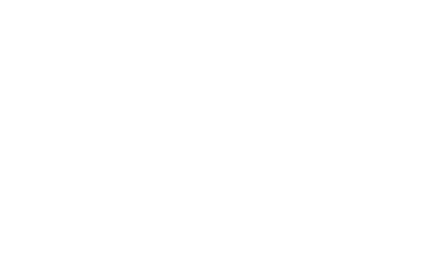

In [31]:
#with ONLY regression line
li_df = []
for V in tqdm.tqdm(li_dist):
    
    df_pair = df_interintra.pivot(index='hen_pair', columns='DOA', values=V).reset_index()
    li_DOA = list(range(119,max(df_interintra['DOA'].tolist())+1))
    #enumerate across the nbr_day_difference value
    for nbr_day in range(1,15):
    #enumerate across day1
        for k1,D1 in enumerate(li_DOA):
            D2 = D1 + nbr_day
            #initialize subplot
            plt.plot(lign_,col_,i)
            plt.tight_layout()
            plt.xticks([]) #remove xlabel annotations
            plt.yticks([])
            plt.axis('off');

            #data
            if (D1 in df_pair.columns) & (D2 in df_pair.columns) :
                df_ = df_pair[[D1,D2]]
                df_ = df_[~(df_.isnull().any(axis=1))]
                x = np.array(df_[D1].tolist())
                y = np.array(df_[D2].tolist())
                #if at least 10 observations
                if (len(x)>0) & (len(x)==len(y)):
                    #measures
                    Explvarscore = explained_variance_score(x, y)
                    RMSE = math.sqrt(mean_squared_error(x, y))
                    MAE = mean_absolute_error(x, y)
                    #Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets
                    #rcoeff2, p_value2 = pearsonr(x, y)
                    rcoeff2, p_value2 = spearmanr(x, y)
                    try:
                        #linear model & it's the 95% CI
                        slope, intercept = np.polyfit(x, y, 1) #degree=1: fit a linear model SVD in Linear Least Squares
                        #TODO: check assumption??? or not as not really using it besides visual?
                        y_model = np.polyval([slope, intercept], x) #evaluate the y_pred by the model
                        x_mean = np.mean(x) ; y_mean = np.mean(y)
                        n = x.size                        # number of samples
                        dof = n - 2                       # degrees of freedom: size-#parameters
                        t_ = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence
                        residual = y - y_model

                        ############### Plot
                        plt.rcParams.update({'font.size': 11})
                        #plot middle line and 95% IC
                        x_line = np.linspace(np.min(x), np.max(x), 100)
                        y_line = np.polyval([slope, intercept], x_line)
                        li_df.append({'level1':D1, 'level2':D2, 'distance_measure':V,'nbr_day':nbr_day, 'rcoeff2':rcoeff2, 
                                      'p_value2':p_value2,
                                     'x_line':x_line, 'y_line':y_line})
                    except Exception as e:
                        print(e)
                        pass
df_hensim_association = pd.DataFrame(li_df)
df_hensim_association['significant'] = df_hensim_association['p_value2'].map(lambda x: x<0.001)
df_hensim_association['DIB'] = df_hensim_association['level1'].map(lambda x: x-118)
#save
df_hensim_association.to_csv(os.path.join(path_extracted_data_visual_adap, id_run+str(rv)+'df_hensim_association.csv'), sep=';', index=False)
print(df_hensim_association.shape)
df_hensim_association.head(3)

In [ ]:
li_dist = ['chi2distance_ALL_15', 'chi2distance', 'DTW_15_all']
df_hensim_association_ = df_hensim_association[(df_hensim_association['distance_measure'].isin(li_dist))&\
                                               (df_hensim_association['level1']<=119+20)].copy()
print(df_hensim_association.shape, df_hensim_association_.shape)
dico_sig_color = {False:'--', True:'-'}
dico_nbrday_color = {1:'red',
                     2:'red',
                     3:'magenta',
                     4:'magenta',
                     5:'yellow',
                     6:'yellow',
                     7:'cyan',
                     8:'cyan',
                     9:'blue',
                     10:'blue',
                     11:'blue',
                     12:'blue',
                     13:'blue',
                     14:'blue',
                     15:'green'}
for V, df_plt in df_hensim_association_.groupby('distance_measure'):
    print('----------------------------------------------- ',V)
    for nbr_day, df_plt_ in df_plt.groupby('nbr_day'):
        for i in range(0, df_plt_.shape[0]):
            x = df_plt_.iloc[i]
            ls = '--'
            plt.plot(x['x_line'], x['y_line'], linewidth=1, color=dico_nbrday_color.get(x['DIB'],'green'), linestyle=dico_sig_color[x['significant']])
            plt.title(V +' number of days in between:'+str(nbr_day))
        #add diagonal line
        plt.axline((0, 0), slope=1, c="black", ls="-.", zorder=0)
        #save
        plt.savefig(os.path.join(path_extracted_data_visual_adap, 'HensSimilarities_'+V+'_'+str(nbr_day)+'.png'), 
                    dpi=400, bbox_inches='tight')
        #plt.show()
        plt.clf();

# Kmeans on all similarites (except first 7 days for whic sim. are not retained)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For n_clusters = 2 The average silhouette_score is : 0.1571422874378553
For n_clusters = 3 The average silhouette_score is : 0.12607241637947522
For n_clusters = 4 The average silhouette_score is : 0.10280471138662148
For n_clusters = 5 The average silhouette_score is : 0.0923816349450734
For n_clusters = 6 The average silhouette_score is : 0.08395238197498141
For n_clusters = 7 The average silhouette_score is : 0.0729718985771422
Please let me know the numbers of clusters you want to search for 4
(8515, 22)


0    0.274692
3    0.260012
2    0.237346
1    0.227951
Name: clID, dtype: float64

DOA,hen_pair,126,129,130,131,132,133,134,135,136,...,141,142,143,144,145,146,147,148,149,clID


,hen_pair,clID,DOA,value
0,hen_1-hen_10,1,126,141.6
1,hen_1-hen_101,2,126,110.2
2,hen_1-hen_102,1,126,91.5


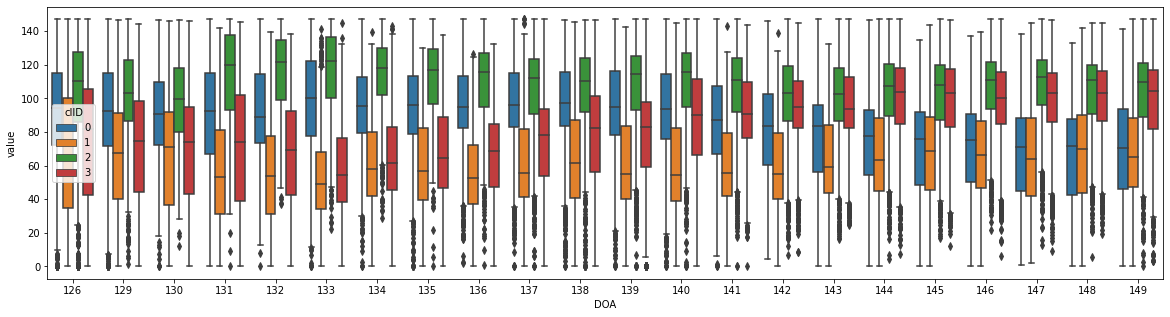

In [130]:
#on all similarities (125-149 (i.e. 3 features), for 8515 observation) n need of PCA with this hge amount of observations
V = 'chi2distance_ALL_15'
V = 'DTW_15_5_Zone'#'DTW_15_all'
df_pair = df_interintra[df_interintra['DOA']>125].pivot(index='hen_pair', columns='DOA', values=V).reset_index()
result, cluster_centers_ = kmeans_clustering(df_pair, range(2,8), ['hen_pair'])
df_pair['clID'] = result
display(df_pair['clID'].value_counts(normalize=True))
li_car = [i for i in df_pair.columns if (i!='hen_pair')&(i!='clID')]
display(df_pair[df_pair['clID'].isnull()])
#df_pair.head(3)
df_plt = pd.melt(df_pair, id_vars=['hen_pair','clID'], value_vars=li_car)
display(df_plt.head(3))
plt.figure(figsize=(20,5))
sns.boxplot(x='DOA', y='value', hue='clID', data=df_plt);

In [129]:
df_pair['clID'].value_counts(normalize=True)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2    0.559131
1    0.248855
0    0.192014
Name: clID, dtype: float64

for i in range(127,149):
    try:
        plt.scatter(df_pair[126].tolist(),df_pair[i].tolist(), c=result, linewidths=0.1)
        plt.xlabel(126)
        plt.ylabel(i)
        plt.show();
    except:
        print(i)

# Kmeans on 2 similarities

In [131]:
df_pair = df_interintra.pivot(index='hen_pair', columns='DOA', values='chi2distance_ALL_15').reset_index()
print(df_pair.shape)
display(df_pair.head(3))

(8515, 30)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,140,141,142,143,144,145,146,147,148,149
0,hen_1-hen_10,82.616001,52.387654,0.431335,NaN,NaN,NaN,44.659625,89.320389,60.429706,...,0.000000,26.338297,40.702363,14.624763,7.487880,21.936624,32.627396,42.098160,47.358855,18.770556
1,hen_1-hen_101,75.844071,85.075360,96.000000,NaN,NaN,NaN,48.129701,92.486211,93.803084,...,53.754848,55.426084,42.038528,57.593855,62.867608,71.645071,94.689979,88.694261,91.595477,91.399992
2,hen_1-hen_102,28.154131,16.129158,0.431335,NaN,NaN,NaN,34.475205,37.297765,0.000000,...,23.190487,28.097817,3.188111,2.810832,2.244541,9.544140,4.721244,13.097191,2.994832,19.661801


In [ ]:
d1 = 139
d2 = d1+1
df_cl = df_pair[['hen_pair',d1,d2]].copy()
result, cluster_centers_ = kmeans_clustering(df_cl, range(2,15), ['hen_pair'])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For n_clusters = 2 The average silhouette_score is : 0.5188991437743062
For n_clusters = 3 The average silhouette_score is : 0.41272073007189514
For n_clusters = 4 The average silhouette_score is : 0.4169001955678669
For n_clusters = 5 The average silhouette_score is : 0.4062089343858379
For n_clusters = 6 The average silhouette_score is : 0.44939471670181363
For n_clusters = 7 The average silhouette_score is : 0.4400008102851095
For n_clusters = 8 The average silhouette_score is : 0.4627814862204913
For n_clusters = 9 The average silhouette_score is : 0.44550420279195335
For n_clusters = 10 The average silhouette_score is : 0.41346856446648966
For n_clusters = 11 The average silhouette_score is : 0.41904343287646045
For n_clusters = 12 The average silhouette_score is : 0.4257733769604305
For n_clusters = 13 The average silhouette_score is : 0.4214489577113435
For n_clusters = 14 The average silhouette_score is : 0.4110222064049902


In [ ]:
for i in range(d1+1,149):
    try:
        plt.scatter(df_pair[d1].tolist(),df_pair[i].tolist(), c=result, linewidths=0.1)
        plt.xlabel(v)
        plt.ylabel(i)
        plt.show();
    except:
        print(i)